---
# Density Based Clustering
# DBSCAN 

Short for Density-Based Spatial Clustering of Applications with Noise, is the most popular density-based clustering method. We attempt to capture our intuition that a cluster is a region of the data space where there are lots of points, surrounded by a region where there are few points.

The goal is to identify dense regions, which can be measured by the number of objects close to a given point.

Parameters:  
**Epsilon (ε):** Is the radius of neighborhood around a point x. It is called called the ε − neighborhood of x.  
**Minimum points (MinPts):** Is the minimum number of neighbors within ε radius.

Any point x in the dataset, with a neighbor count greater than or equal to MinPts, is marked as a core point. We say that x is border point, if the number of its neighbors is less than MinPts, but it belongs to the
ε − neighborhood of some core point xi. Finally, if a point is neither a core nor a border point, then it is called a noise point or anomalous.

![](../img/ad10.png)

- The number of clusters does not need to be known a priori.
- Recovers much more flexible cluster shapes than K-means, which can
only find spherical clusters.
- Intrinsically finds and labels outliers as such, making it a great solution for anomaly detection.
- It works with any distance function. (e.g. "euclidean", "manhattan", "jaccard", and "levenshtein" )

## Comparison of methods

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
import pandas as pd
import numpy as np

In [4]:
dataset = pd.read_csv('../datasets/sensor_data.csv')

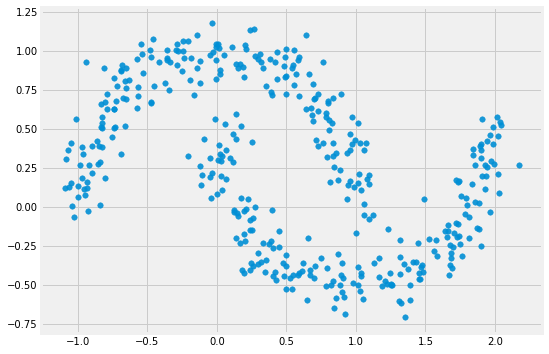

In [5]:
plt.figure(figsize=[8, 6])
plt.scatter(dataset['0'], dataset['1'], s=30, alpha=0.9)

How would it work with K-means?

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset)

In [7]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 2)
clusters = model.fit_predict(X_scaled)

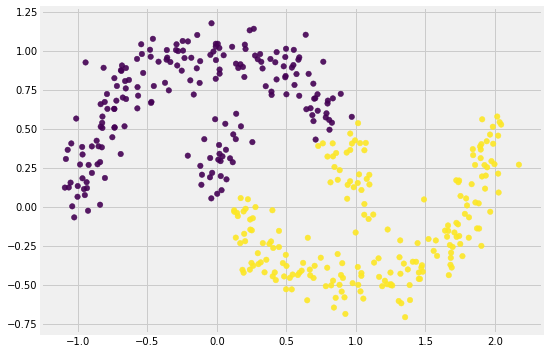

In [8]:
plt.figure(figsize=[8, 6])
plt.scatter(dataset['0'], dataset['1'], s=30, alpha=0.9, c=clusters)

Now let's see with DBSCAN

In [9]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=4) #radius and min_core_neighbors

In [10]:
clusters = dbscan.fit_predict(X_scaled)

In [11]:
set(clusters)

{-1, 0, 1}

To compute DBSCAN we’ll go point by point and check if it is a core point or not. If it is a core point we will create a new cluster, then search through all of its neighbors. We’ll add the neighborhoods of all these points to the cluster. If one of the points is a core point as well, it’s neighborhood will be added to our search. This will continue until we cannot reach anymore points. Then we’ll move on to the next point that we haven’t visited/labeled yet.

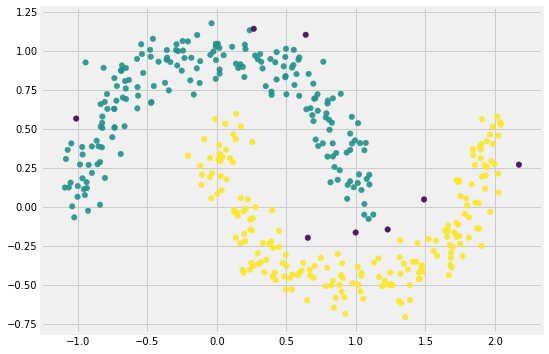

In [12]:
plt.figure(figsize=[8, 6])
plt.scatter(dataset['0'], dataset['1'], s=30, alpha=0.9, c=clusters)

### Expected anomalies

![](../img/sigmas.png)

In [13]:
expected = int(round(len(dataset)*(1-.954),0))
expected

In [15]:
anomalies = []
for e in np.arange(0.1, 1, 0.01):
    for m in range(1,10):
        model = DBSCAN(eps=e, min_samples = m)
        clusters = model.fit_predict(X_scaled)
        unique, counts = np.unique(clusters, return_counts=True)
        anomalies.append((e,m,counts[0]))
grid_table = pd.DataFrame(anomalies)
grid_table.columns = ['eps','min_neigh','noise']

In [16]:
grid_table_exp = grid_table[grid_table.noise < expected]

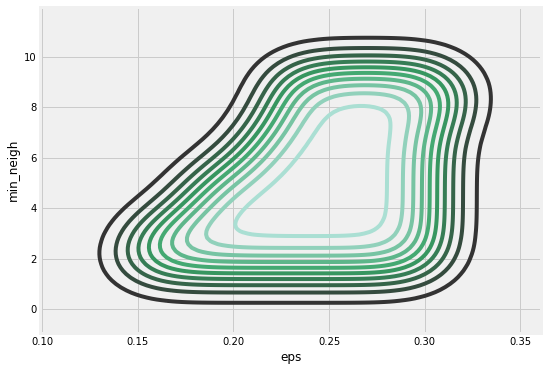

In [17]:
plt.figure(figsize=[8, 6])
sns.kdeplot(grid_table_exp.eps, grid_table_exp.min_neigh)

- Affinity Propagation
- Mean Shift
- Spectral Clustering
- Agglomerative Clustering
- HDBSCAN  
[Here](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html)

---
# Contextual Anomalies  
#### (Conditional Outliers)
<img src="../img/contextual.png" width="400">

These type of anomalies occur when a record is only considered anomalous when it is compared within the context of other **metainformation**.

Contextual anomalies are considered in applications where the dataset has a combination of
**observational** attributes and **behaviour** attributes.

Most of the time requires a pre-processing step to determine what the contexts actually are.

- Spatial  
The records in the dataset include features which identify locational information for the record. 
- Graph  
The records are related to other records as per some graph structure
- Sequential  
The records can be considered as a sequence within one another.
- Profile  
The records can be clustered within profiles that may not have
explicit temporal or spatial contextualities.

### Anomalies on test responding

Values are not outside the normal global range but are abnormal compared to the expected time to respond.
Also depends on the type of respondent and the environment.

### Multiple sclerosis test in an app
It is mainly important to analyze all the features involved in every test taken by a person, and it is straightforward thinking that not all tasks are with full concentration because the nature of the tool, is an app, and we might expect the people taking the test can get distracted by some random reason.

The main objective here is to analyze any pattern related to the time in milliseconds a participant spend on responding every visual task, the test goes for 90 sec.

In [18]:
dataset = pd.read_csv('../datasets/ms_experiment.csv')

In [19]:
dataset.columns

Index(['_id', 'userId', 'correct.answers', 'ms', 'timestamp', 'response_ms',
       'symbol', 'trial'],
      dtype='object')

In [20]:
dataset.describe()

,correct.answers,ms,response_ms,trial
count,11420.000000,11420.000000,11420.000000,11420.000000
mean,48.789229,0.694921,1837.626182,24.561559
std,8.862138,0.460461,631.816594,14.717046
min,13.000000,0.000000,80.000000,1.000000
25%,42.000000,0.000000,1445.000000,12.000000
50%,49.000000,1.000000,1712.000000,24.000000
75%,55.000000,1.000000,2082.000000,36.000000
max,67.000000,1.000000,20649.000000,61.000000


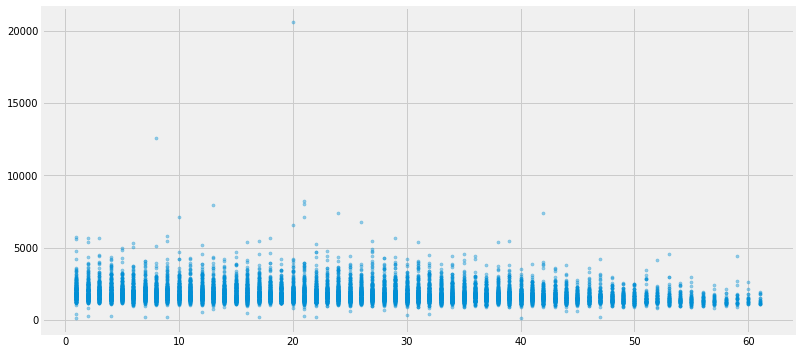

In [21]:
plt.figure(figsize=[12, 6])
plt.scatter(dataset['trial'], dataset['response_ms'], s=10, alpha=0.4)

### Population of Study

In [22]:
print('{} Data points distribuited among {} Participants'.format(
    len(dataset), len(dataset.userId.unique())))

11420 Data points distribuited among 23 Participants


We choose the score variable as the number of correct answers on every test

In [23]:
#Split the patients MS (Multiple Sclerosis) and HC (Health Control)
df_ms = dataset[dataset['ms']==1]
df_hc = dataset[dataset['ms']==0]

In [24]:
print('Patients on MS group: {}\nPatients on HC group: {}'.format(
    len(df_ms.userId.unique()),len(df_hc.userId.unique())))

Patients on MS group: 15
Patients on HC group: 8


Text(0.5,1,'Scores Distribution MS and HC Groups')

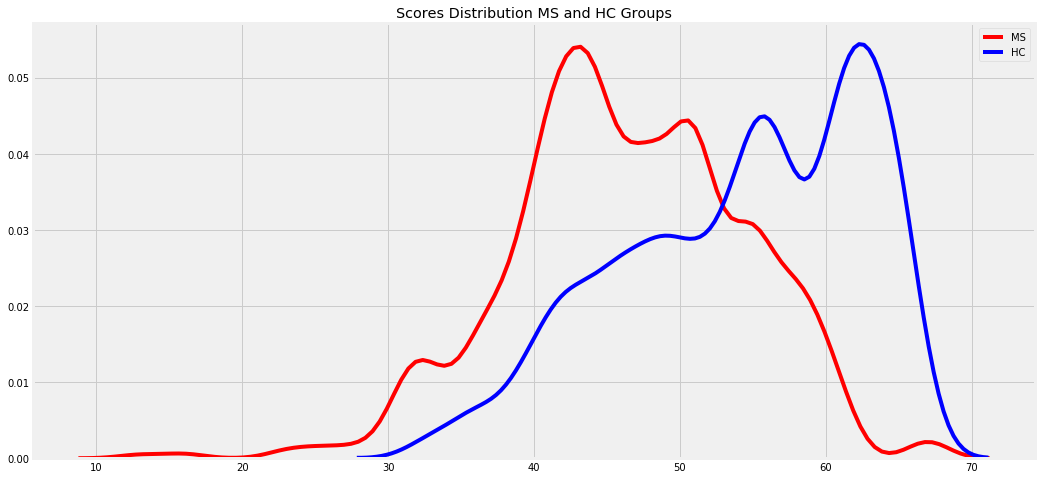

In [25]:
plt.figure(figsize=[8, 6])
sns.kdeplot(dataset[dataset['ms']==1]['correct.answers'], color='red', label='MS')
sns.kdeplot(dataset[dataset['ms']==0]['correct.answers'], color='blue', label='HC')
plt.title('Scores Distribution MS and HC Groups')

<img src="../img/ms1.png" width="700">

<img src="../img/ms2.png" width="700">

<img src="../img/ms3.png" width="700">

<img src="../img/ms4.png" width="700">